# Compare VTF Detection Results with Ground-Truth
**Author**: Ana M Tarano

**Last Modified**: July 31, 2025

**Description**: Converts all analyzed volcanoes to one merged csv that is compared to ground-truth data collected by science team.

## All Results

In [1]:
import os
import glob
import pandas as pd
import numpy as np

# Find all the results files
files = glob.glob("../results/**/*_res.csv", recursive=True)
num_files = len(files)
print(f"Found {num_files} files.")

# Iterate through the Volcanic Regions and save a new dataframe with results
columns = [
    "Date", "Volcano", "Volcanic Region",
    "P: Volcanic Thermal Anomaly (Y/N)",
    "P: Maximum (K)",
    "P: Mean (Background Temperature) (K)",
    "P: Standard Deviation",
    "P: Max Temp Above Background (K)",
    "GT: Volcanic Thermal Anomaly (Y/N)",
    "GT: Maximum (K)",
    "GT: Mean (Background Temperature) (K)",
    "GT: Standard Deviation",
    "GT: Max Temp Above Background (K)",
    "GT: Clouds",
    "GT: Comments"
]
merged = pd.DataFrame(columns=columns)

for file in files:
    # Read in predictions
    file_paths_parsed = file.split('/')
    volcanic_region = file_paths_parsed[-2]
    volcano = file_paths_parsed[-1].replace("_res.csv", "")
    volcano_prediction = pd.read_csv(file)
    if volcano_prediction.empty:
        print(volcano, " in ", volcanic_region, " has an empty csv.")
        print("     This could be because the files' CRS are Clarke 1866 and not in EPSG format.")

    # Read in ground truth (gt)
    volcanic_region_gt_path = "../../data/CloudFree_ASTER_files/Volcano_Thermal_TimeSeries_Spreadsheets/" 
    volcano_gt_file = os.path.join(volcanic_region_gt_path, volcanic_region, volcanic_region+"_DataTable.xlsx")
    volcano_gt = pd.read_excel(volcano_gt_file, sheet_name=volcano).rename(
            columns = {'Maximum (K)': 'GT: Maximum (K)',
                       'Mean Background Temperature (K)': 'GT: Mean (Background Temperature) (K)',
                       'Max Temp Above Background (K)': 'GT: Max Temp Above Background (K)',
                       'Standard Deviation': 'GT: Standard Deviation',
                       } )

    # Convert dates to datetime format
    volcano_prediction["Date"] = pd.to_datetime(volcano_prediction["Date"], errors="coerce")
    volcano_gt["Date"] = pd.to_datetime(volcano_gt["Date"], errors="coerce")

    # Merge on Date
    combined = pd.merge(volcano_prediction, volcano_gt, on="Date", how="outer")

    # Add volcano name
    combined["Volcano"] = volcano
    combined["Volcanic Region"] = volcanic_region

    # Extract and rename columns into final format
    formatted = pd.DataFrame({
        "Date": combined["Date"],
        "Volcano": combined["Volcano"],
        "Volcanic Region": combined["Volcanic Region"],
        "P: Volcanic Thermal Anomaly (Y/N)": combined.get("Volcanic Thermal Anomaly (Y/N)", None),
        "P: Maximum (K)": combined.get("Maximum (K)", None),
        "P: Mean (Background Temperature) (K)": combined.get("Mean (Background Temperature) (K)", None),
        "P: Standard Deviation": combined.get("Standard Deviation", None),
        "P: Max Temp Above Background (K)": combined.get("Max Temp Above Background (K)", None),
        "P: Filename": combined.get("Filename", None),
        "GT: Volcanic Thermal Anomaly (Y/N)": combined.apply(
    lambda row: (
        'Y' if (
            (
                isinstance(row.get('VTF area'), (int, float)) and not pd.isna(row['VTF area']) and row['VTF area'] > 0
            ) or (
                isinstance(row.get('VTF area'), str) and row['VTF area'].strip() and row['VTF area'].strip().lower() != "nan"
            ) or (
                isinstance(row.get('VTF area Structure'), (int, float)) and not pd.isna(row['VTF area Structure']) and row['VTF area Structure'] > 0
            ) or (
                isinstance(row.get('VTF area Structure'), str) and row['VTF area Structure'].strip() and row['VTF area Structure'].strip().lower() != "nan"
            )
        )
        else (
            'N' if (
                (
                    (isinstance(row.get('VTF area'), (int, float)) and row['VTF area'] == 0) or
                    (isinstance(row.get('VTF area'), (int, float)) and row['VTF area'] == np.nan) or
                    (isinstance(row.get('VTF area Structure'), (int, float)) and row['VTF area Structure'] == 0)
                )
            )
            else np.nan
        )
    ),
    axis=1
),
        "GT: Maximum (K)": combined.get("GT: Maximum (K)", None),
        "GT: Mean (Background Temperature) (K)": combined.get("GT: Mean (Background Temperature) (K)", None),
        "GT: Standard Deviation": combined.get("GT: Standard Deviation", None),
        "GT: Max Temp Above Background (K)": combined.get("GT: Max Temp Above Background (K)", None),
        "GT: Clouds": combined.get("Clouds (Y/N), Only Y if there is a potential for the clouds to effect the anom", None),
        "GT: Comments": combined.get("Comments", None),
    })

    # Append to full merged DataFrame

    merged = pd.concat([merged, formatted], ignore_index=True)


Found 209 files.
Saunders  in  Antarctica  has an empty csv.
     This could be because the files' CRS are Clarke 1866 and not in EPSG format.
Izu_Torishima  in  Japan_Taiwan_Marianas  has an empty csv.
     This could be because the files' CRS are Clarke 1866 and not in EPSG format.
Pagan  in  Japan_Taiwan_Marianas  has an empty csv.
     This could be because the files' CRS are Clarke 1866 and not in EPSG format.
Kirishimayama  in  Japan_Taiwan_Marianas  has an empty csv.
     This could be because the files' CRS are Clarke 1866 and not in EPSG format.
Hakoneyama  in  Japan_Taiwan_Marianas  has an empty csv.
     This could be because the files' CRS are Clarke 1866 and not in EPSG format.
Hokkaido_Komagatake  in  Japan_Taiwan_Marianas  has an empty csv.
     This could be because the files' CRS are Clarke 1866 and not in EPSG format.
Asosan  in  Japan_Taiwan_Marianas  has an empty csv.
     This could be because the files' CRS are Clarke 1866 and not in EPSG format.
South_Sarigan_Sea

## Merge into one csv file: "merged_results_cleaned.csv"

In [2]:

print(combined.head())
# Define a function that applies the logic
def compute_sum(row):
    if pd.isna(row["GT: Maximum (K)"]) and pd.notna(row["GT: Mean (Background Temperature) (K)"]) and pd.notna(row["GT: Max Temp Above Background (K)"]):
        return row["GT: Mean (Background Temperature) (K)"] + row["GT: Max Temp Above Background (K)"]
    else:
        return row["GT: Maximum (K)"]  # Or you can return np.nan

# Apply the function to create a new column
merged["GT: Maximum (K)"] = merged.apply(compute_sum, axis=1)
merged = merged[merged["P: Volcanic Thermal Anomaly (Y/N)"].notna()]
merged.to_csv("merged_results_cleaned.csv")

   Unnamed: 0       Date       Volcano Volcanic Thermal Anomaly (Y/N)  \
0           0 2005-03-22  Unnamed_20_8                              N   
1           1 2013-04-04  Unnamed_20_8                              N   
2           2 2016-02-08  Unnamed_20_8                              N   
3           3 2005-03-13  Unnamed_20_8                              Y   
4           4 2005-08-20  Unnamed_20_8                              N   

   Maximum (K)  Mean (Background Temperature) (K)  Standard Deviation  \
0          NaN                                NaN                 NaN   
1          NaN                                NaN                 NaN   
2          NaN                                NaN                 NaN   
3        305.0                           291.4575            6.396614   
4          NaN                                NaN                 NaN   

   Max Temp Above Background (K)  \
0                            NaN   
1                            NaN   
2             

## Compare VTF results to ground-truth

9657  images to ground truth results.


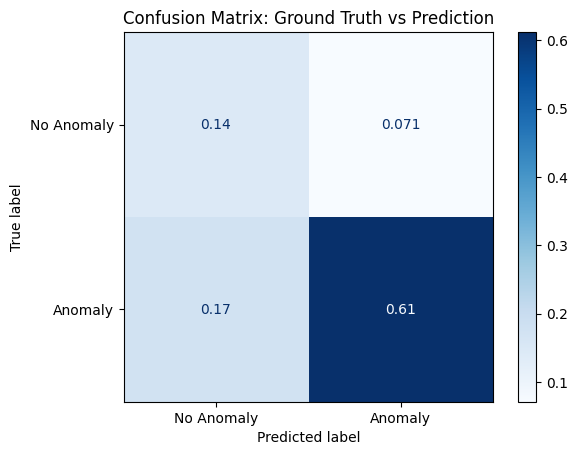

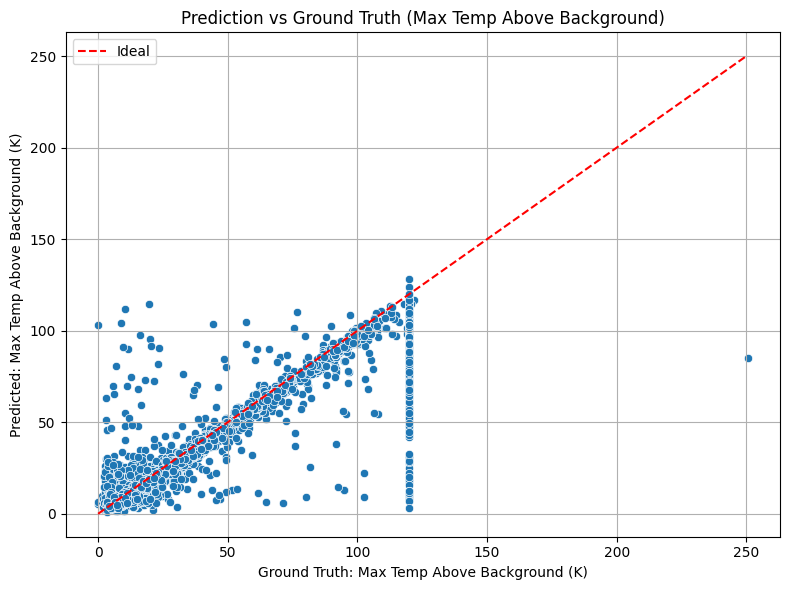

MAE: 5.33 K
R² Score: 0.82


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score

# Load the merged results   
df = pd.read_csv("merged_results_cleaned.csv")

# Filter valid classification pairs
cls_mask = df["GT: Volcanic Thermal Anomaly (Y/N)"].isin(["Y", "N"])

cls_df = df[cls_mask]
print(len(cls_df), ' images to ground truth results.')

y_true = cls_df["GT: Volcanic Thermal Anomaly (Y/N)"]
y_pred = cls_df["P: Volcanic Thermal Anomaly (Y/N)"]

# Convert to binary (Y=1, N=0)
y_true_bin = (y_true == "Y").astype(int)
y_pred_bin = (y_pred == "Y").astype(int)

# Plot classification confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Anomaly", "Anomaly"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Ground Truth vs Prediction")
plt.show()

# Plot regression error: Max Temp Above Background
reg_df = df[ 
    df["GT: Volcanic Thermal Anomaly (Y/N)"].str.contains('Y') &
    df["GT: Max Temp Above Background (K)"].notna() &
    df["P: Max Temp Above Background (K)"].notna() # &
]

x = reg_df["GT: Max Temp Above Background (K)"]
y = reg_df["P: Max Temp Above Background (K)"]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label="Ideal")
plt.xlabel("Ground Truth: Max Temp Above Background (K)")
plt.ylabel("Predicted: Max Temp Above Background (K)")
plt.title("Prediction vs Ground Truth (Max Temp Above Background)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print error metrics
mae = mean_absolute_error(x, y)
r2 = r2_score(x, y)
print(f"MAE: {mae:.2f} K")
print(f"R² Score: {r2:.2f}")


### Cloudy Data

630


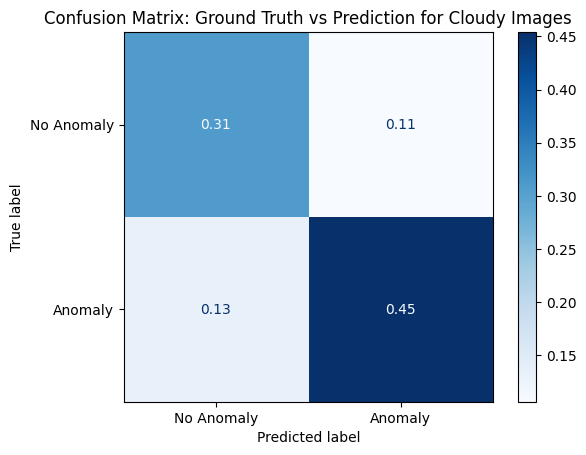

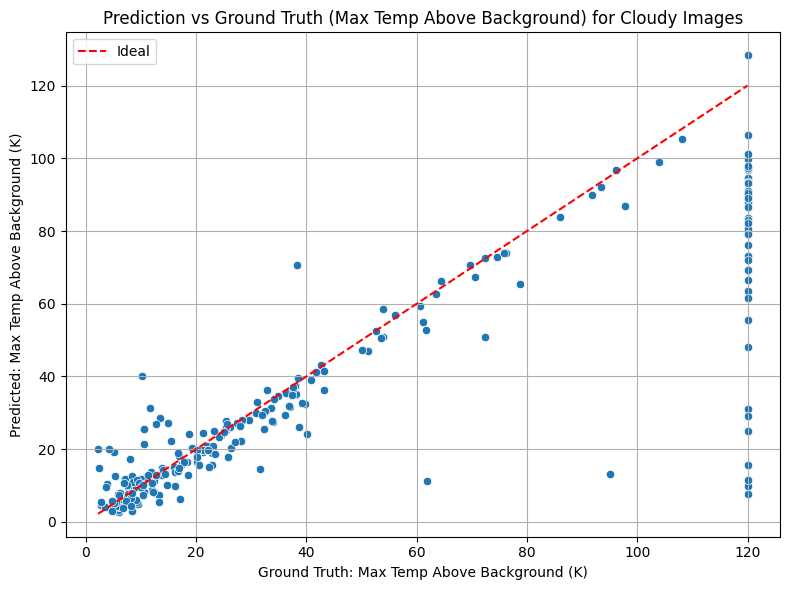

MAE: 11.47 K
R² Score: 0.69


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score

# Load the merged results   
df = pd.read_csv("merged_results_cleaned.csv")

# Filter valid classification pairs
cls_mask = df["GT: Volcanic Thermal Anomaly (Y/N)"].isin(["Y", "N"]) & (
    df["GT: Comments"].str.lower().str.contains('cloud', na=False) | 
    df["GT: Clouds"].str.contains('Y', na=False) |
    df["GT: Clouds"].str.lower().str.contains('interfer', na=False) 
    ) 

cls_df = df[cls_mask]

filtered_count = len(cls_df)
print(filtered_count)

y_true = cls_df["GT: Volcanic Thermal Anomaly (Y/N)"]
y_pred = cls_df["P: Volcanic Thermal Anomaly (Y/N)"]

# Convert to binary (Y=1, N=0)
y_true_bin = (y_true == "Y").astype(int)
y_pred_bin = (y_pred == "Y").astype(int)

# Plot classification confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Anomaly", "Anomaly"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Ground Truth vs Prediction for Cloudy Images")
plt.show()


# Plot regression error: Max Temp Above Background
reg_df = df[ 
    df["GT: Volcanic Thermal Anomaly (Y/N)"].str.contains('Y') &
    (
        df["GT: Comments"].str.lower().str.contains('cloud', na=False) | 
        df["GT: Clouds"].str.contains('Y', na=False) |
        df["GT: Clouds"].str.lower().str.contains('interfer', na=False) 
    ) & 
    df["GT: Max Temp Above Background (K)"].notna() &
    df["P: Max Temp Above Background (K)"].notna()
]

x = reg_df["GT: Max Temp Above Background (K)"]
y = reg_df["P: Max Temp Above Background (K)"]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label="Ideal")
plt.xlabel("Ground Truth: Max Temp Above Background (K)")
plt.ylabel("Predicted: Max Temp Above Background (K)")
plt.title("Prediction vs Ground Truth (Max Temp Above Background) for Cloudy Images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print error metrics
mae = mean_absolute_error(x, y)
r2 = r2_score(x, y)
print(f"MAE: {mae:.2f} K")
print(f"R² Score: {r2:.2f}")


### Submarine data

26  images that are from submarine volcanoes.


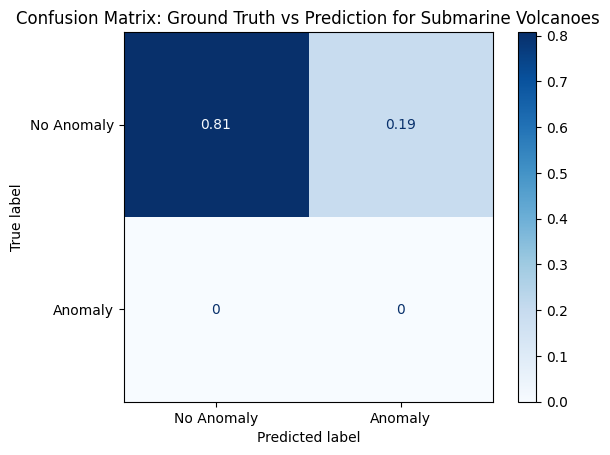

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score

# Load the merged results   
df = pd.read_csv("merged_results_cleaned.csv")

# Filter valid classification pairs
cls_mask = df["GT: Volcanic Thermal Anomaly (Y/N)"].isin(["Y", "N"]) & (
    df["GT: Comments"].str.lower().str.contains('submarine', na = False)) 

cls_df = df[cls_mask]
print(len(cls_df), ' images that are from submarine volcanoes.')

y_true = cls_df["GT: Volcanic Thermal Anomaly (Y/N)"]
y_pred = cls_df["P: Volcanic Thermal Anomaly (Y/N)"]

# Convert to binary (Y=1, N=0)
y_true_bin = (y_true == "Y").astype(int)
y_pred_bin = (y_pred == "Y").astype(int)

# Plot classification confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Anomaly", "Anomaly"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Ground Truth vs Prediction for Submarine Volcanoes")
plt.show()


### Lava Flows

168  images that include lava flows.


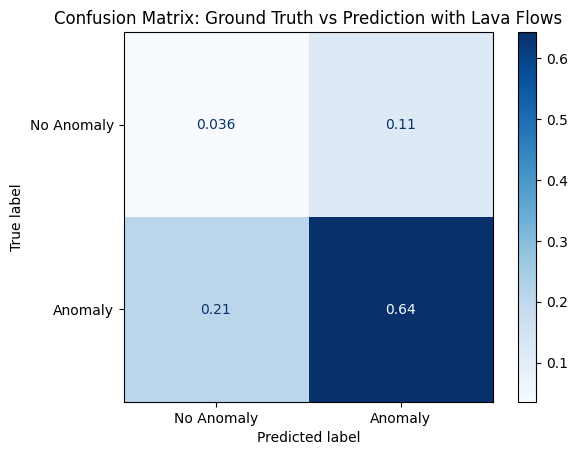

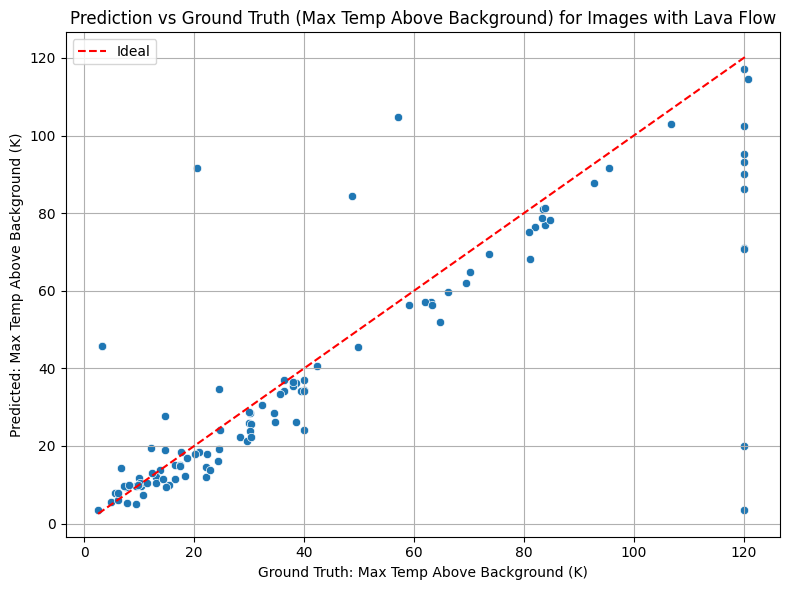

MAE: 10.17 K
R² Score: 0.66


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score

# Load the merged results   
df = pd.read_csv("merged_results_cleaned.csv")

# Filter valid classification pairs
cls_mask = df["GT: Volcanic Thermal Anomaly (Y/N)"].isin(["Y", "N"]) & (
    df["GT: Comments"].str.lower().str.contains('lava', na = False)) 

cls_df = df[cls_mask]
print(len(cls_df), ' images that include lava flows.')

y_true = cls_df["GT: Volcanic Thermal Anomaly (Y/N)"]
y_pred = cls_df["P: Volcanic Thermal Anomaly (Y/N)"]

# Convert to binary (Y=1, N=0)
y_true_bin = (y_true == "Y").astype(int)
y_pred_bin = (y_pred == "Y").astype(int)

# Plot classification confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Anomaly", "Anomaly"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Ground Truth vs Prediction with Lava Flows")
plt.show()

# Plot regression error: Max Temp Above Background
reg_df = df[ 
    df["GT: Volcanic Thermal Anomaly (Y/N)"].str.contains('Y') & 
    df["GT: Max Temp Above Background (K)"].notna() &
    df["P: Max Temp Above Background (K)"].notna()  &
    df["GT: Comments"].str.lower().str.contains('lava', na = False)
]

x = reg_df["GT: Max Temp Above Background (K)"]
y = reg_df["P: Max Temp Above Background (K)"]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label="Ideal")
plt.xlabel("Ground Truth: Max Temp Above Background (K)")
plt.ylabel("Predicted: Max Temp Above Background (K)")
plt.title("Prediction vs Ground Truth (Max Temp Above Background) for Images with Lava Flow")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print error metrics
mae = mean_absolute_error(x, y)
r2 = r2_score(x, y)
print(f"MAE: {mae:.2f} K")
print(f"R² Score: {r2:.2f}")


## Provide result comparisons by region

                   Volcanic Region  Samples        TN        FP        FN  \
0               Africa_and_Red_Sea     2553  0.281614  0.201794  0.128251   
1                           Alaska     2136  0.143770  0.057508  0.142705   
2                       Antarctica      445  0.000000  0.000000  0.085106   
3                   Atlantic_Ocean      435  0.245536  0.098214  0.276786   
4           Canada_and_Western_USA      157  0.000000  0.013889  0.166667   
5         Hawaii_and_Pacific_Ocean      164  0.053097  0.000000  0.035398   
6         Iceland_and_Arctic_Ocean      634  0.688525  0.073770  0.032787   
7                        Indonesia     3801  0.075305  0.031008  0.227021   
8            Japan_Taiwan_Marianas      509  0.020305  0.020305  0.121827   
9      Kamchatka_and_Mainland_Asia     1325  0.101695  0.063174  0.214176   
10                   Kuril_Islands     1673  0.147309  0.130312  0.203966   
11  Mediterranean_and_Western_Asia       84  0.000000  0.012195  0.000000   

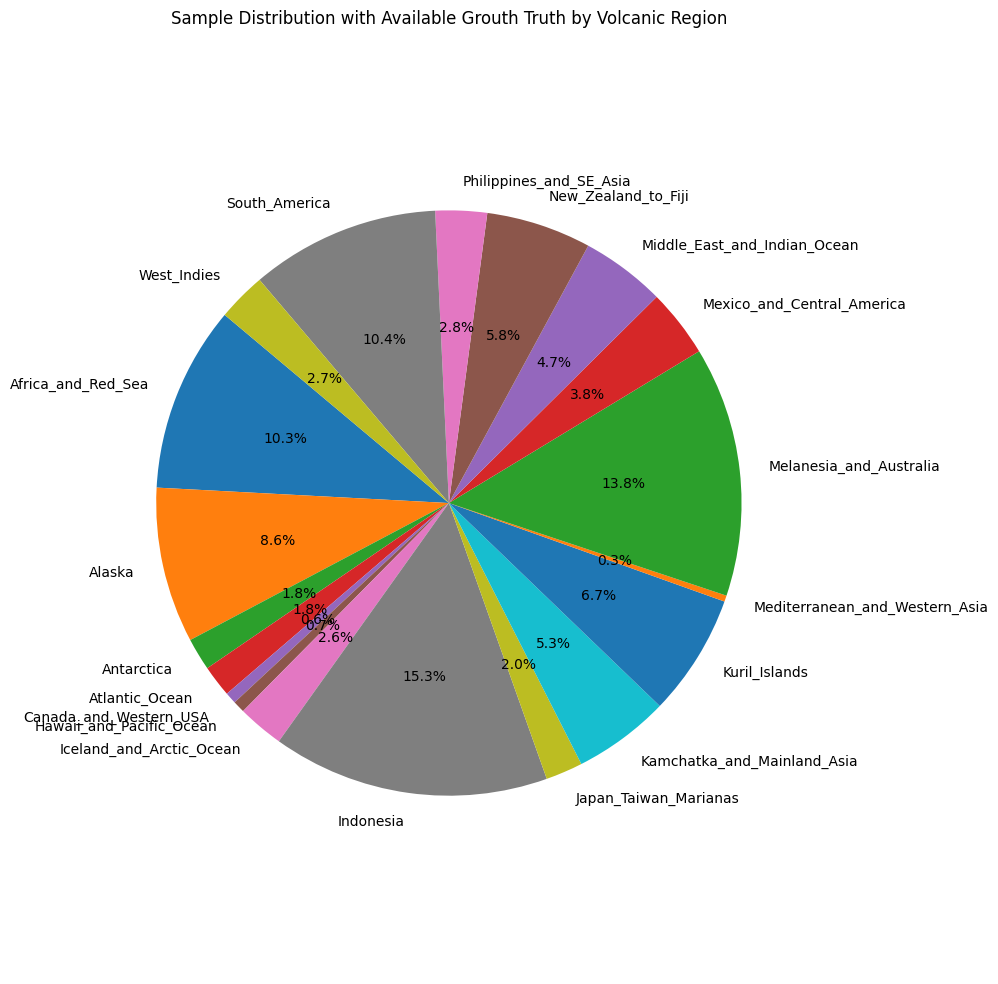

In [7]:
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# Load the merged results   
merged = pd.read_csv("merged_results_cleaned.csv")

# Initialize summary
region_summary = []

# Group and compute metrics
for region, group in merged.groupby("Volcanic Region"):
    # Classification
    cls_df = group[
        group["GT: Volcanic Thermal Anomaly (Y/N)"].isin(["Y", "N"])
    ]
    y_true = (cls_df["GT: Volcanic Thermal Anomaly (Y/N)"] == "Y").astype(int)
    y_pred = (cls_df["P: Volcanic Thermal Anomaly (Y/N)"] == "Y").astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="all")
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Regression: Max Temp Above Background
    reg_df = group[
        group["GT: Max Temp Above Background (K)"].notna() &
        group["P: Max Temp Above Background (K)"].notna()
    ]
    x = reg_df["GT: Max Temp Above Background (K)"]
    y = reg_df["P: Max Temp Above Background (K)"]
    mae = mean_absolute_error(x, y) if not reg_df.empty else None
    r2 = r2_score(x, y) if not reg_df.empty else None

    region_summary.append({
        "Volcanic Region": region,
        "Samples": len(group),
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "MAE (Max Temp Above BG)": mae,
        "R² (Max Temp Above BG)": r2
    })

# Final summary table
summary_df = pd.DataFrame(region_summary)
print(summary_df)

# Create a pie chart showing number of samples by volcanic region
plt.figure(figsize=(10, 10))
plt.pie(summary_df["Samples"], labels=summary_df["Volcanic Region"], autopct="%1.1f%%", startangle=140)
plt.title("Sample Distribution with Available Grouth Truth by Volcanic Region")
plt.axis("equal")
plt.tight_layout()
plt.show()


### Error type by region

                   Volcanic Region  Samples        TN        FP        FN  \
11  Mediterranean_and_Western_Asia       84  0.000000  0.012195  0.000000   
6         Iceland_and_Arctic_Ocean      634  0.688525  0.073770  0.032787   
5         Hawaii_and_Pacific_Ocean      164  0.053097  0.000000  0.035398   
15             New_Zealand_to_Fiji     1442  0.371486  0.122490  0.044177   
13      Mexico_and_Central_America      934  0.028387  0.025806  0.063226   
2                       Antarctica      445  0.000000  0.000000  0.085106   
8            Japan_Taiwan_Marianas      509  0.020305  0.020305  0.121827   
0               Africa_and_Red_Sea     2553  0.281614  0.201794  0.128251   
1                           Alaska     2136  0.143770  0.057508  0.142705   
12         Melanesia_and_Australia     3431  0.297735  0.097087  0.145631   
4           Canada_and_Western_USA      157  0.000000  0.013889  0.166667   
10                   Kuril_Islands     1673  0.147309  0.130312  0.203966   

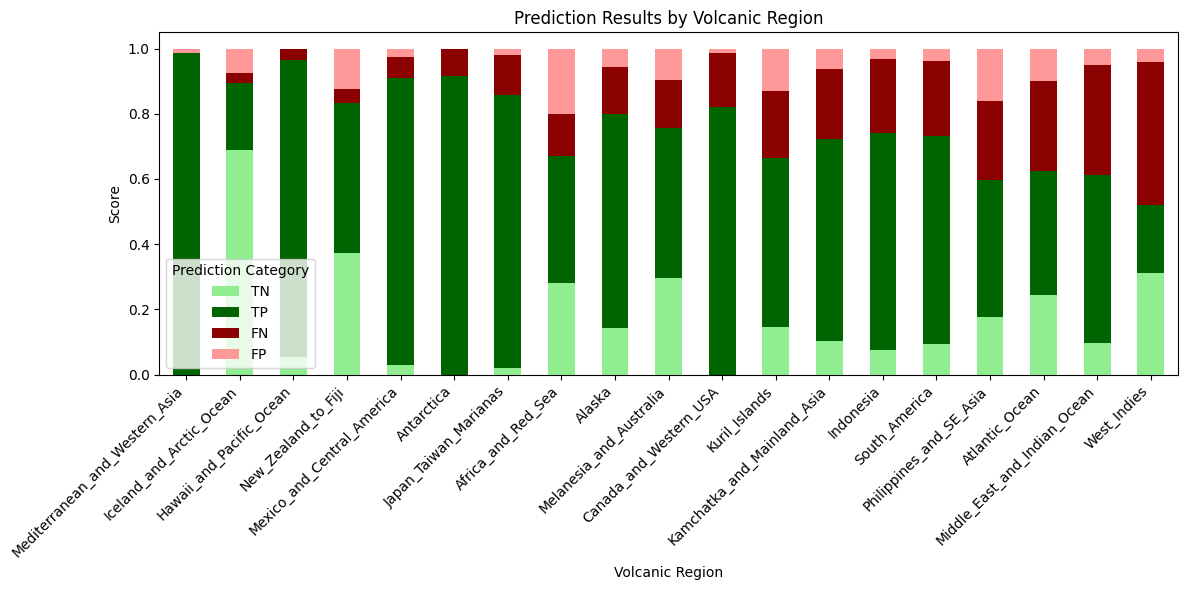

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = {
    'TN': '#90ee90',  # lime green
    'TP': '#006400',  # green
    'FN': '#8b0000',  # red
    'FP': '#ff9999',  # pink
}

summary_df = summary_df.sort_values(by="FN", ascending=True)
print(summary_df)

# Plot stacked bar chart
summary_df[['Volcanic Region', 'TN','TP', 'FN', 'FP']].plot(x='Volcanic Region', 
                                                            kind="bar", 
                                                            stacked=True, 
                                                            figsize=(12, 6),
                                                            color=[colors['TN'], colors['TP'], colors['FN'], colors['FP']])
plt.title("Prediction Results by Volcanic Region")
plt.xlabel("Volcanic Region")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Prediction Category", loc="lower left")
plt.tight_layout()
plt.show()


### Error metrics by region

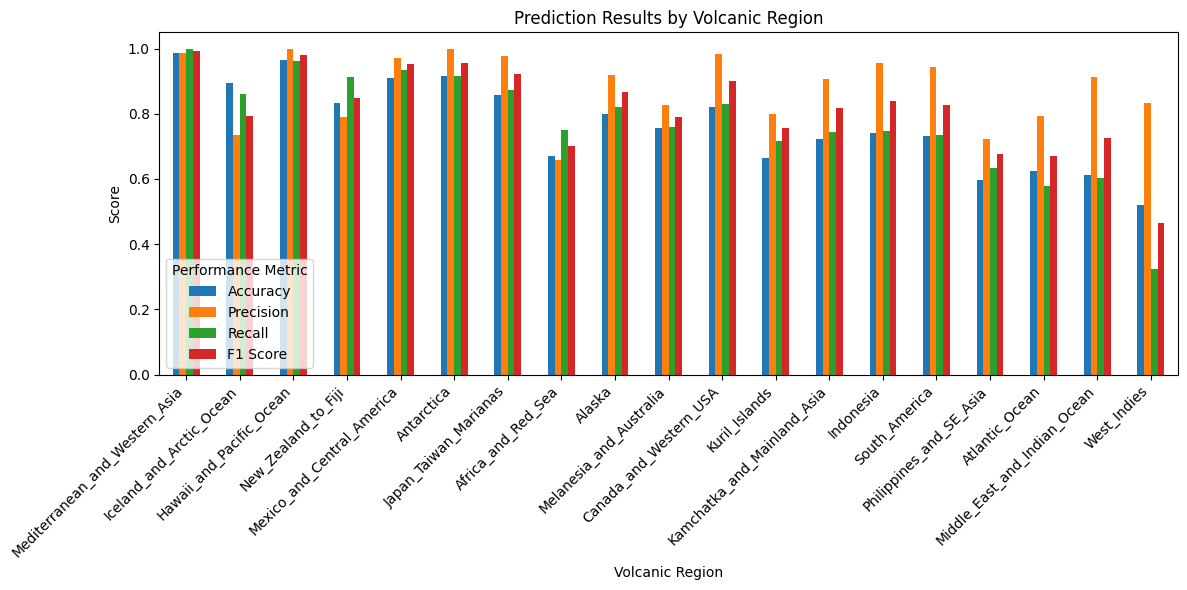

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot stacked bar chart
summary_df[['Volcanic Region', 'Accuracy','Precision', 'Recall', 'F1 Score']].plot(x='Volcanic Region', 
                                                            kind="bar", 
                                                            stacked=False, 
                                                            figsize=(12, 6)
                                                            )
plt.title("Prediction Results by Volcanic Region")
plt.xlabel("Volcanic Region")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Performance Metric", loc = 'lower left')
plt.tight_layout()
plt.show()


## Plot First 20 Volcanoes as Time Series

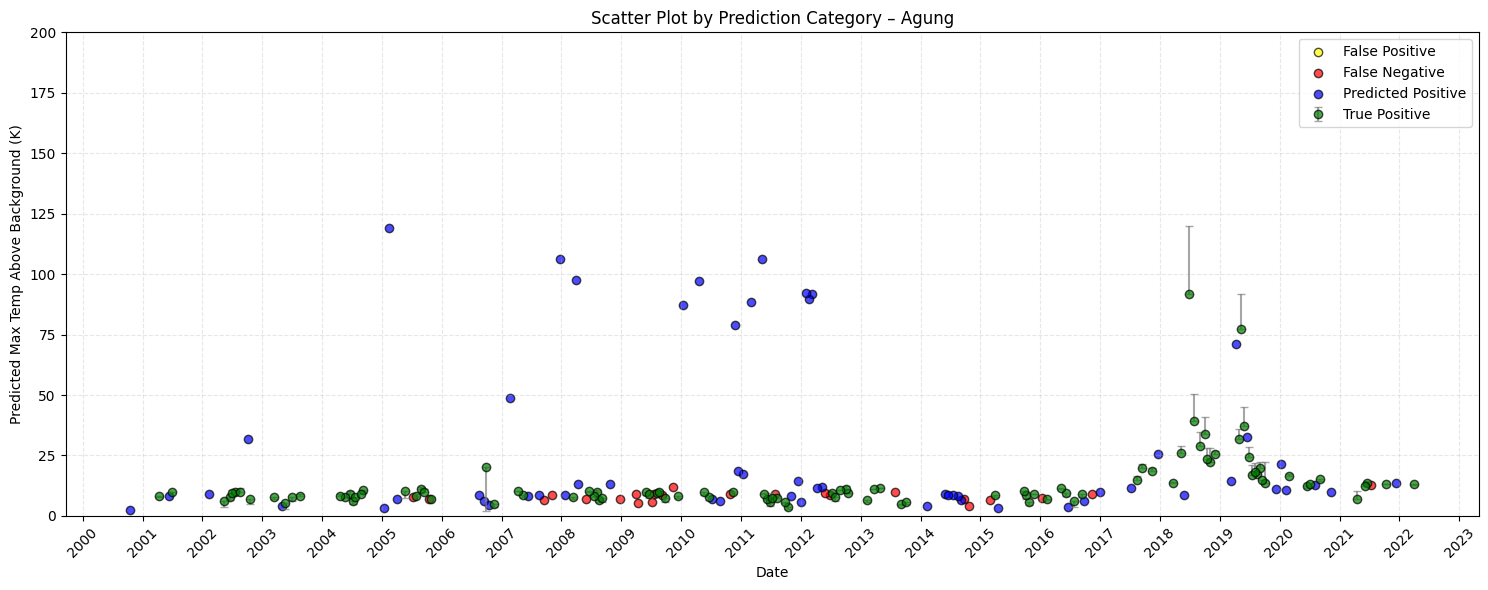

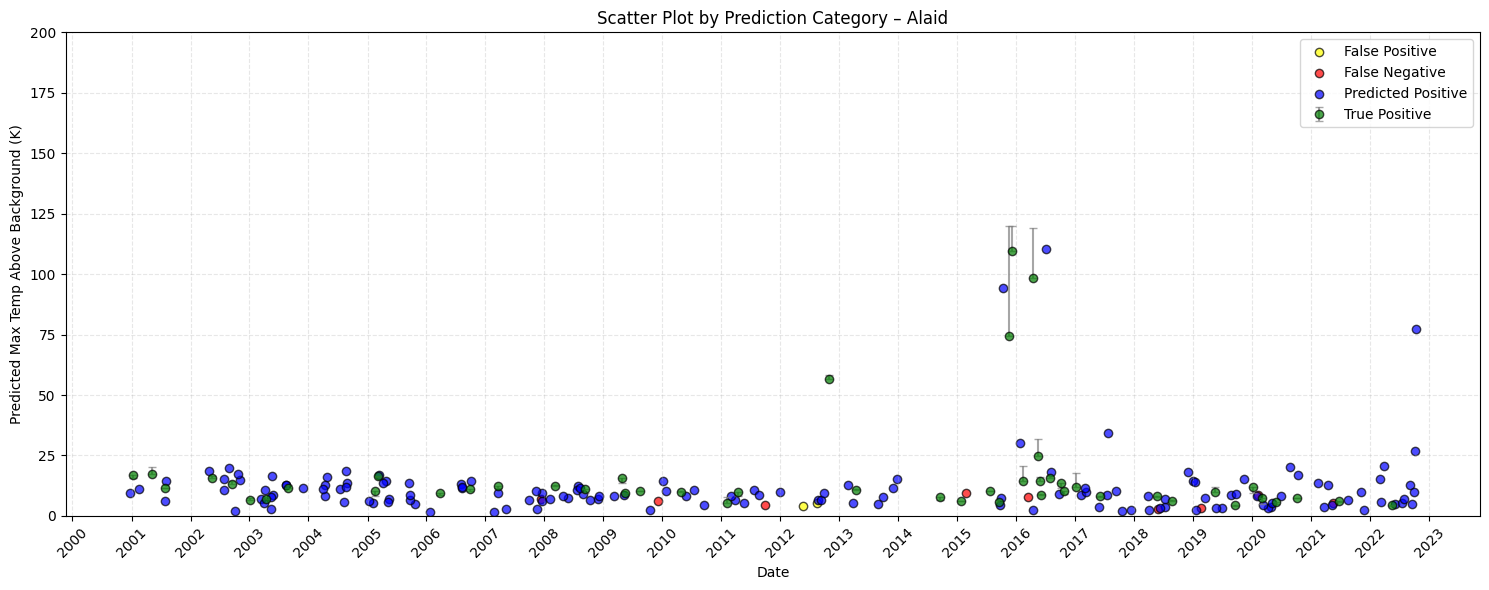

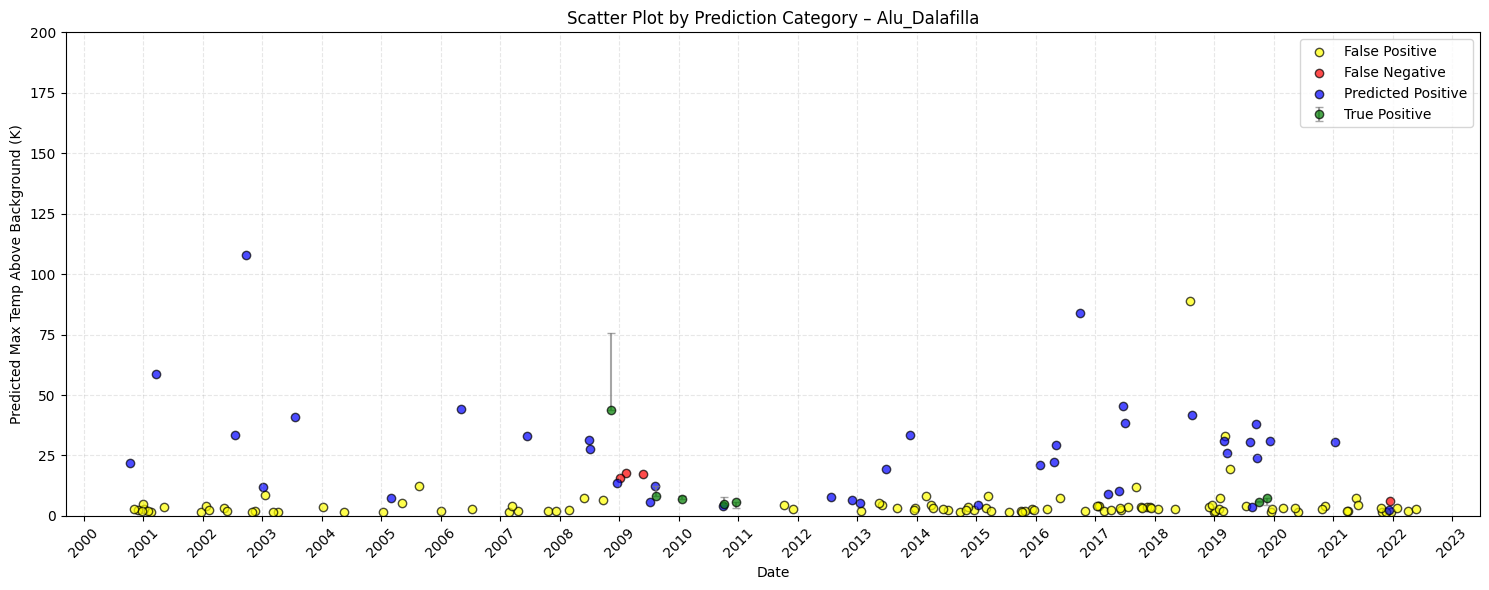

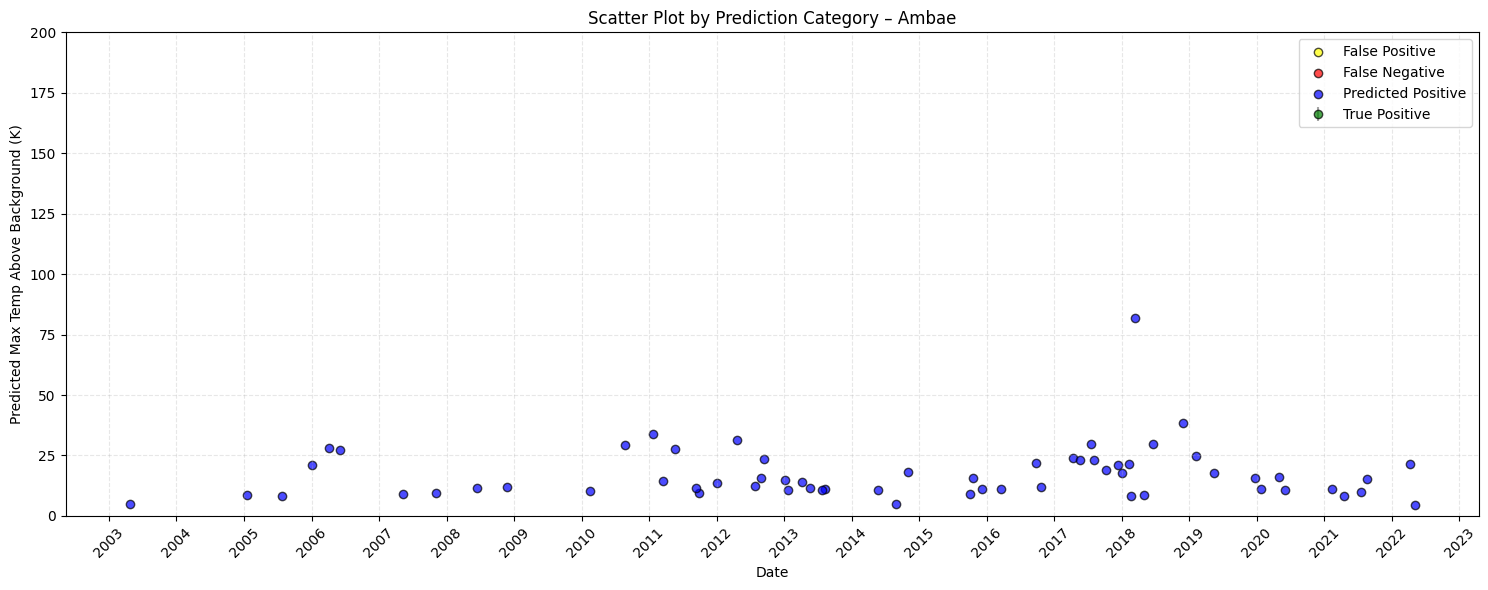

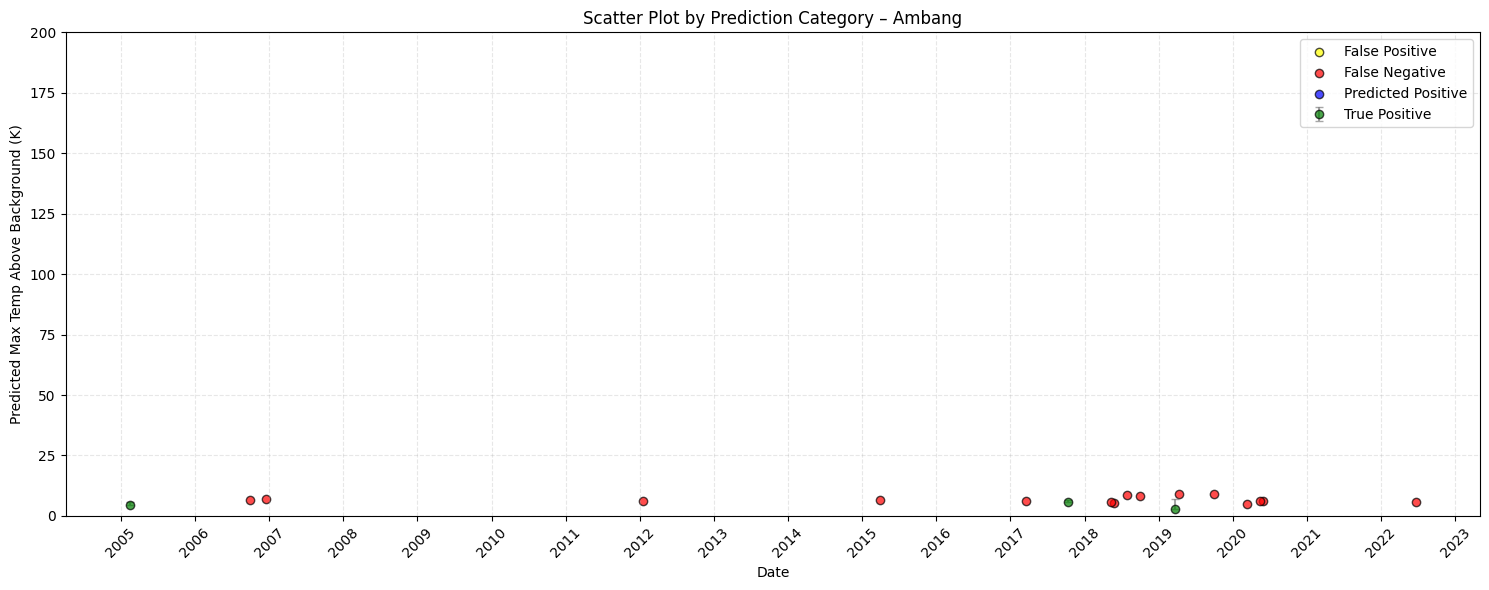

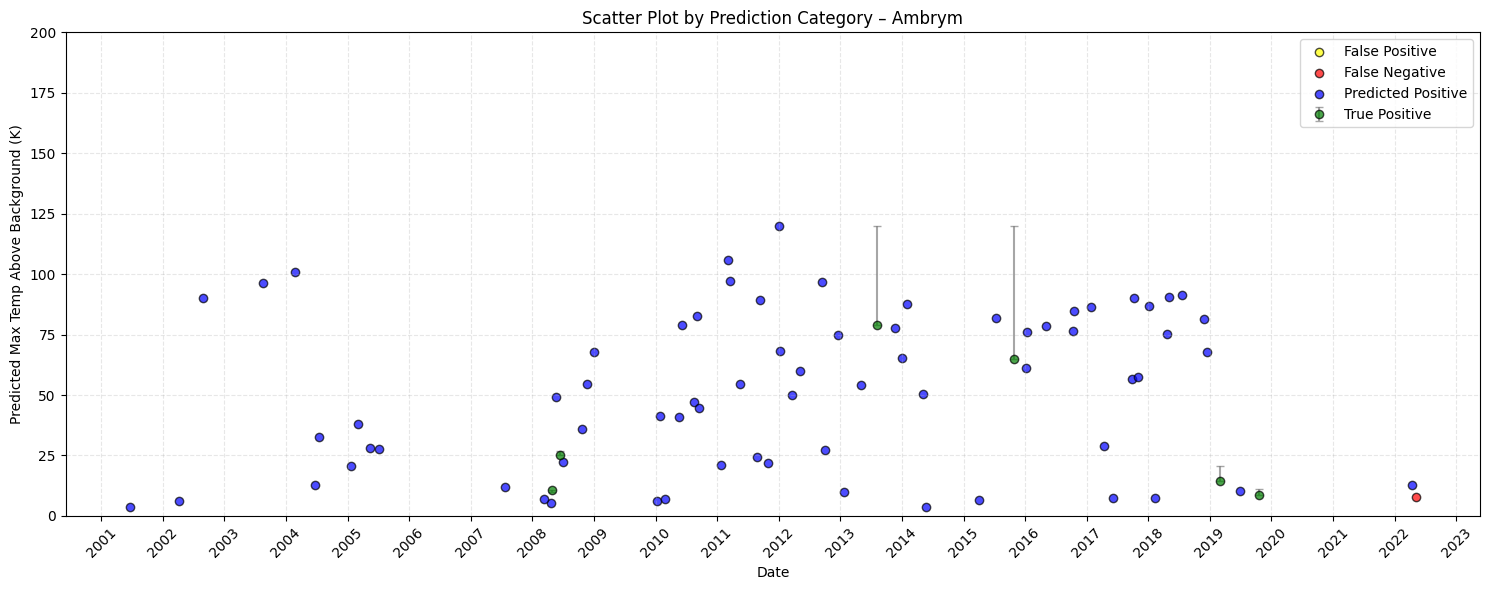

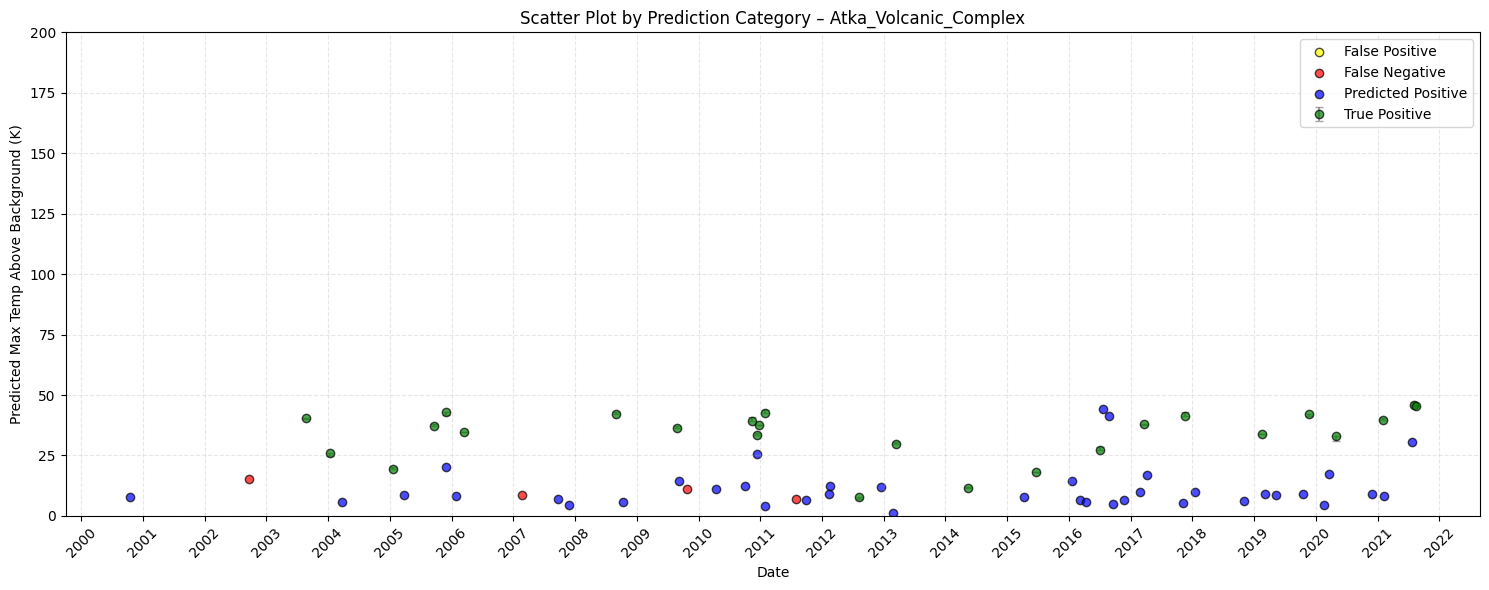

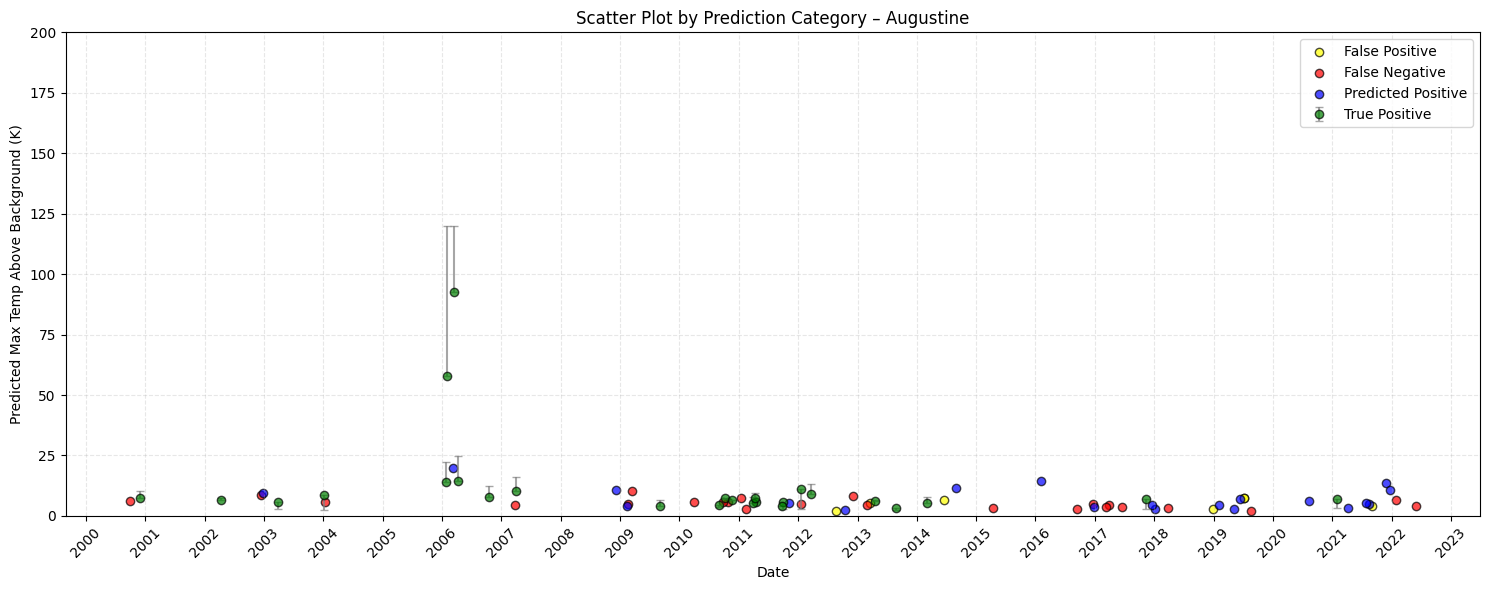

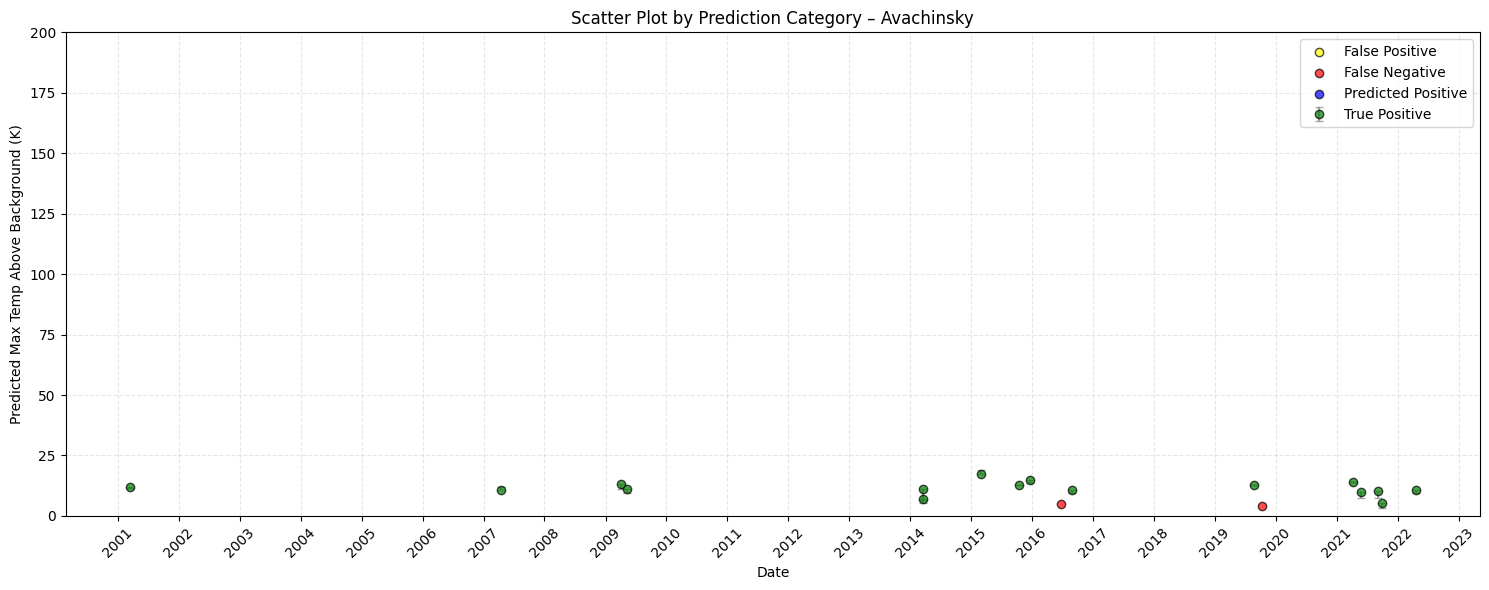

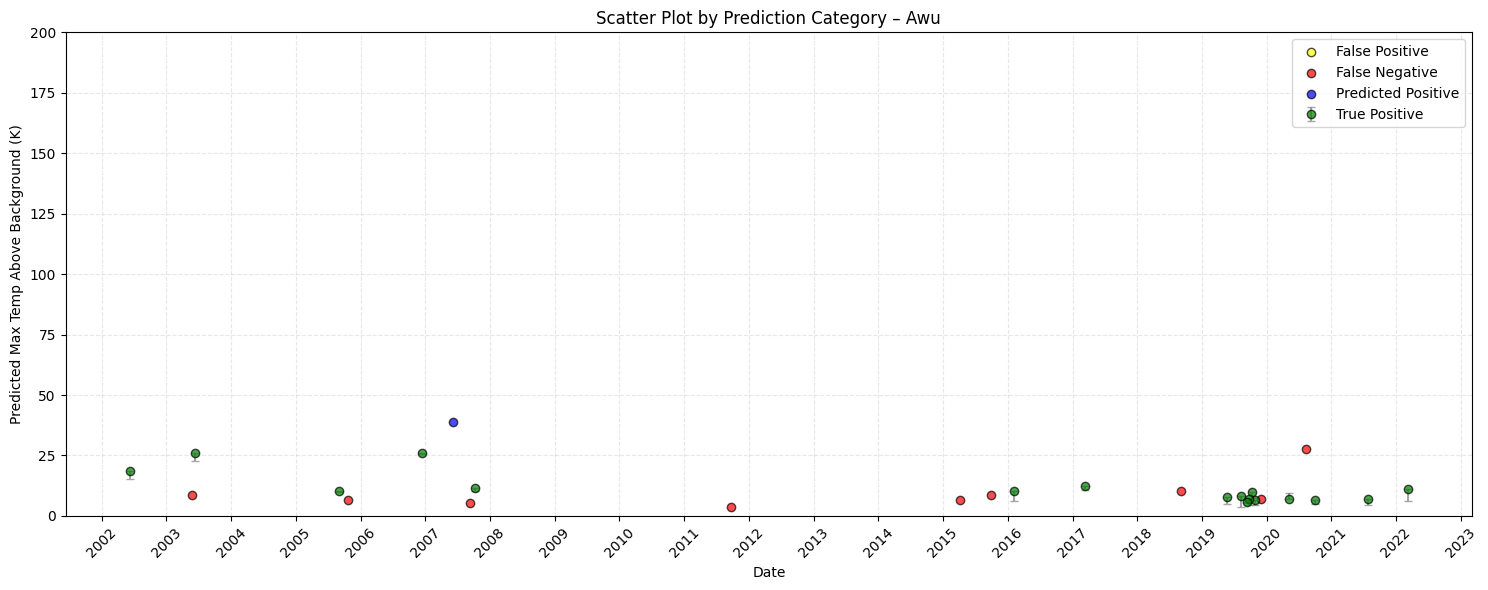

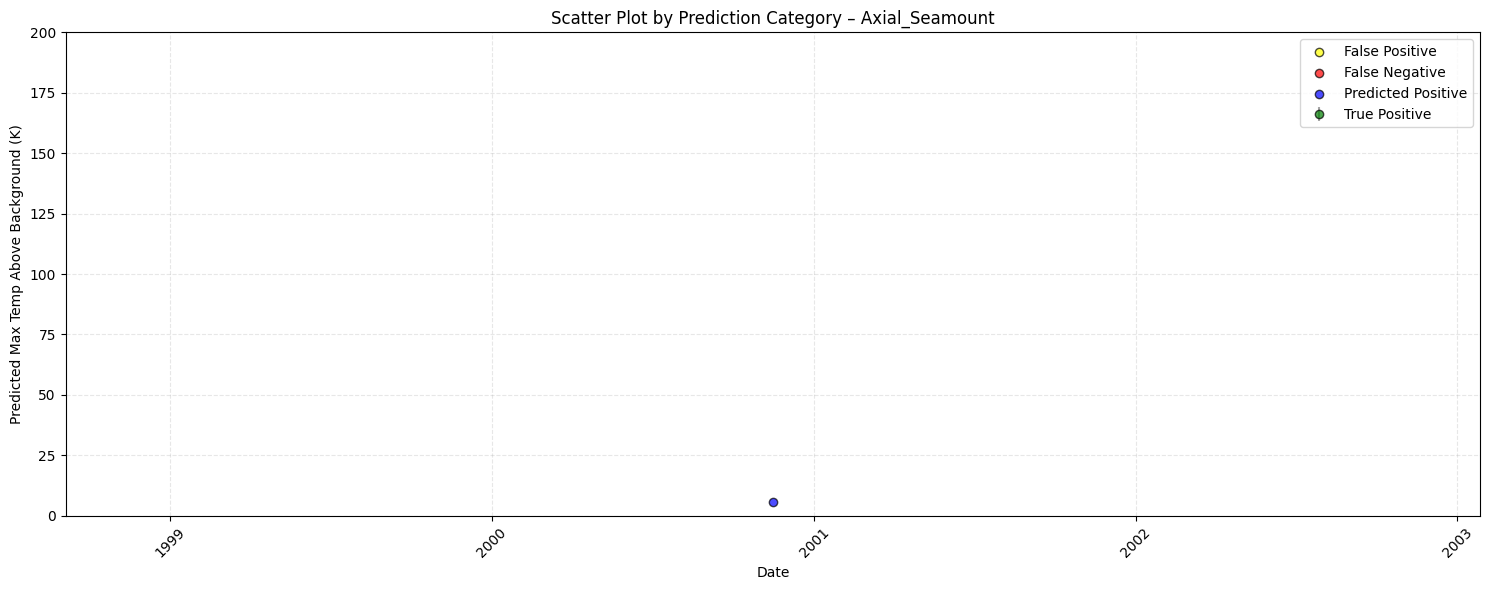

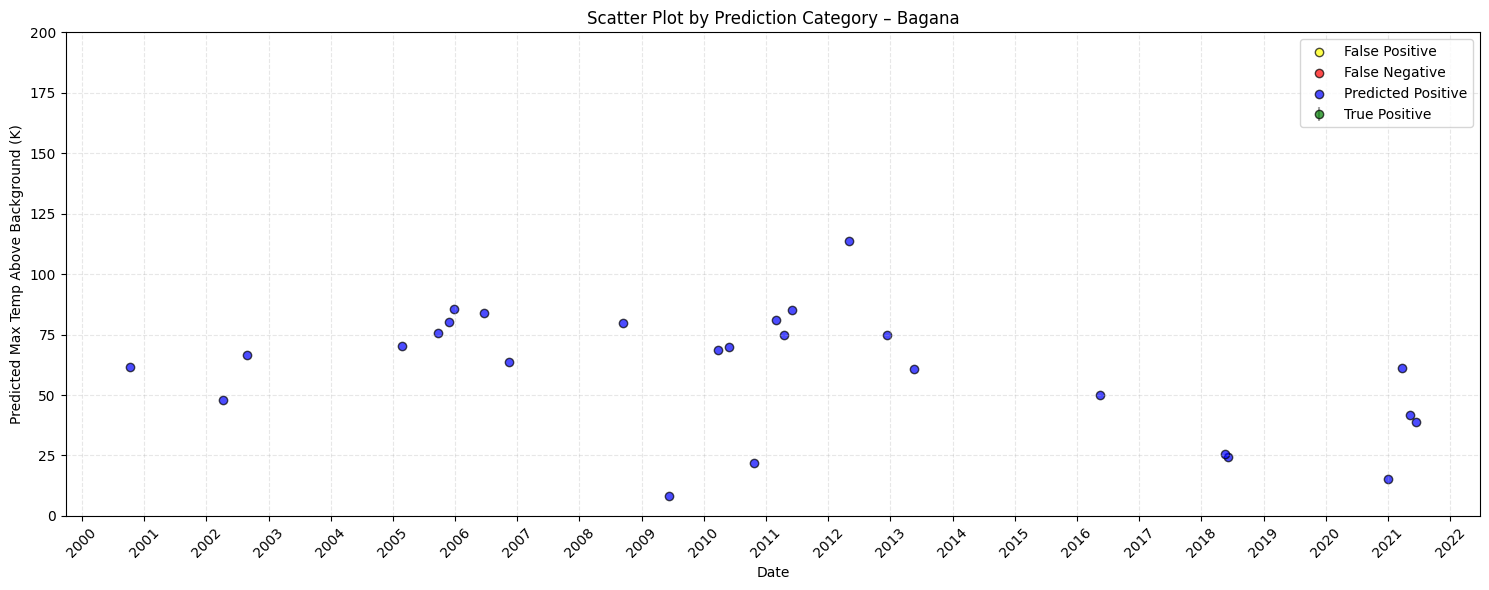

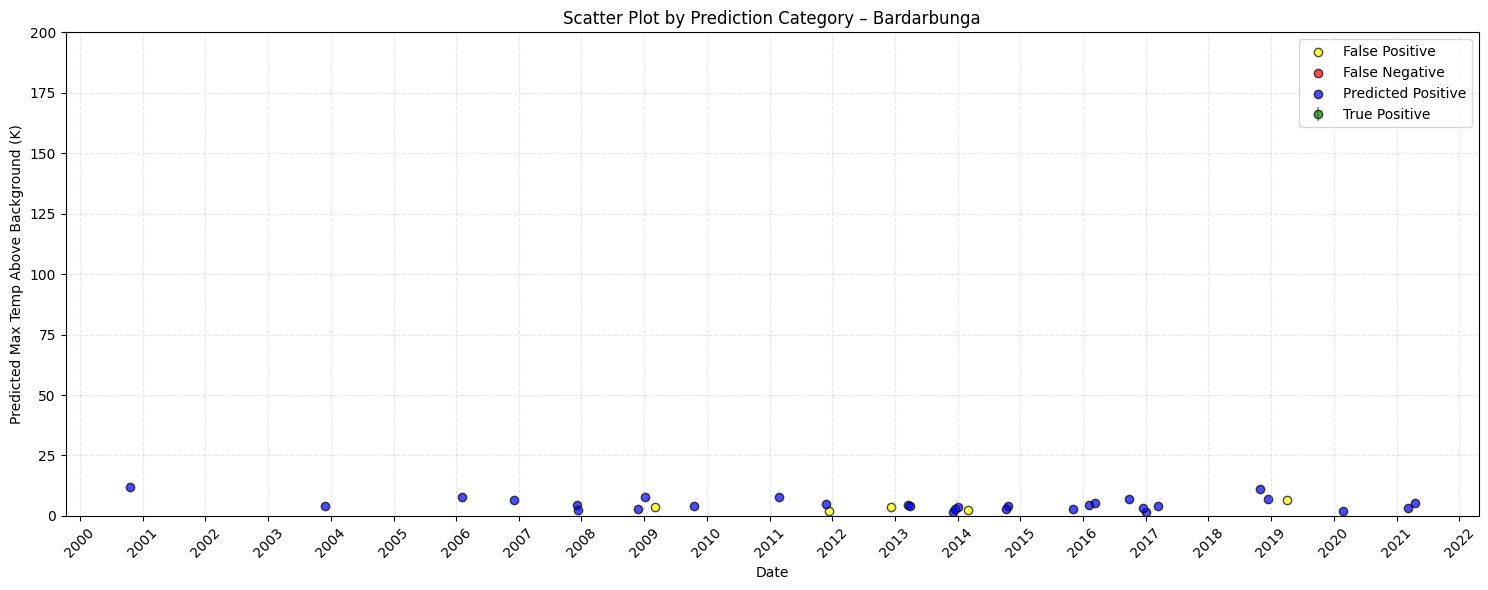

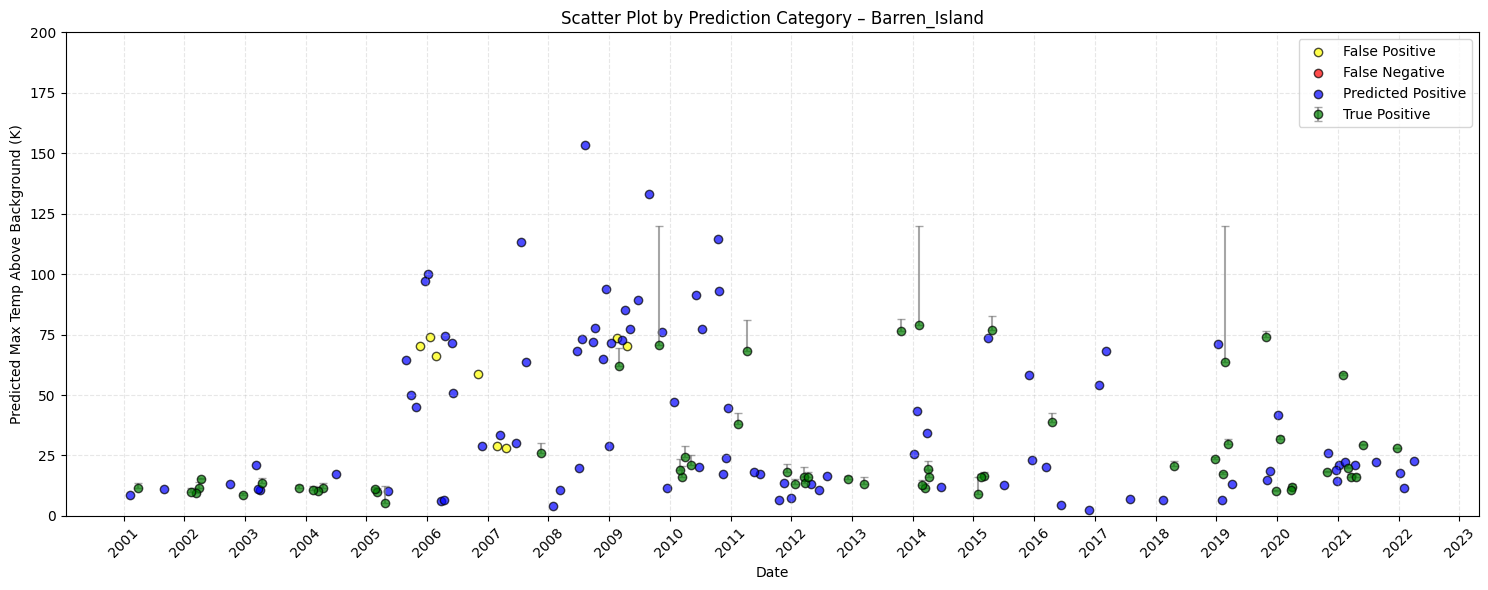

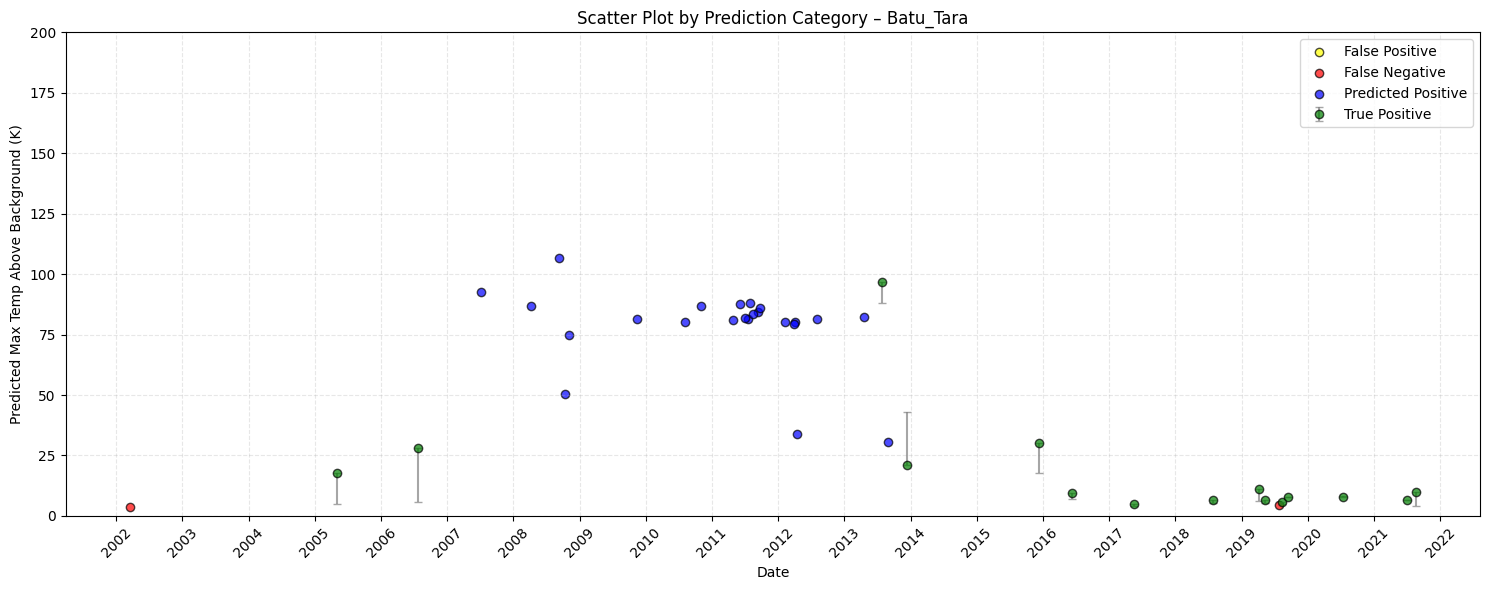

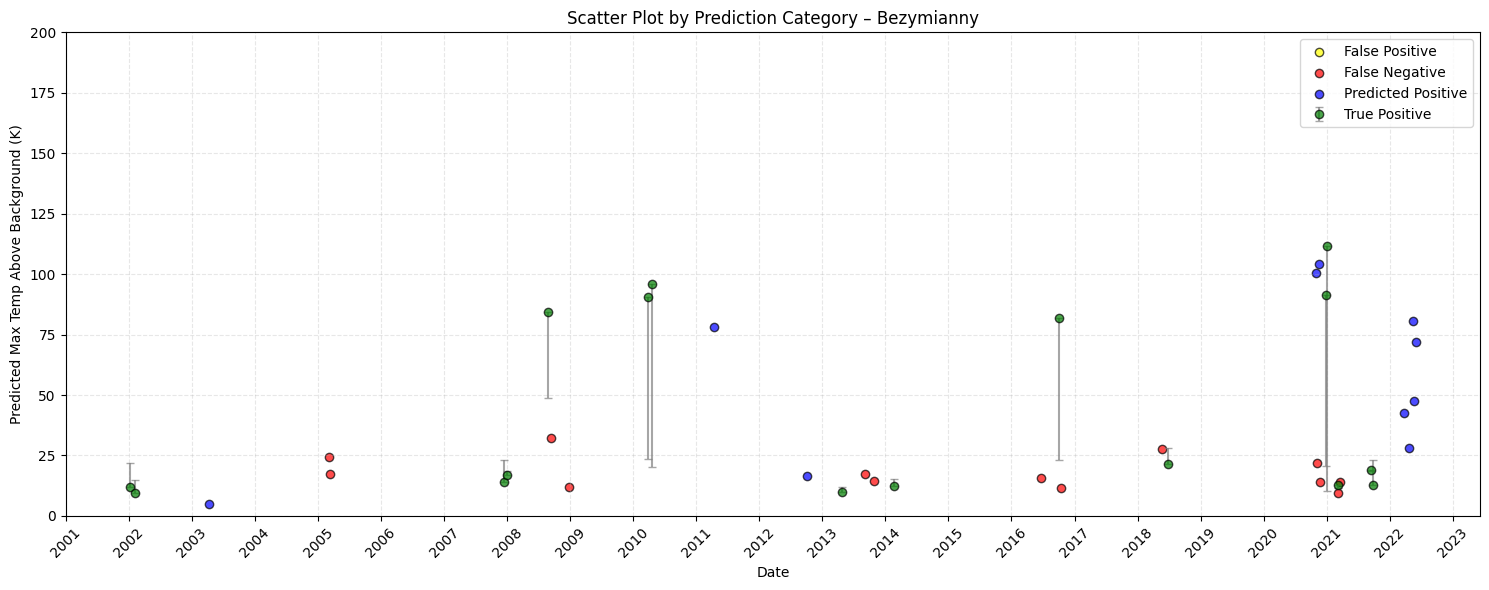

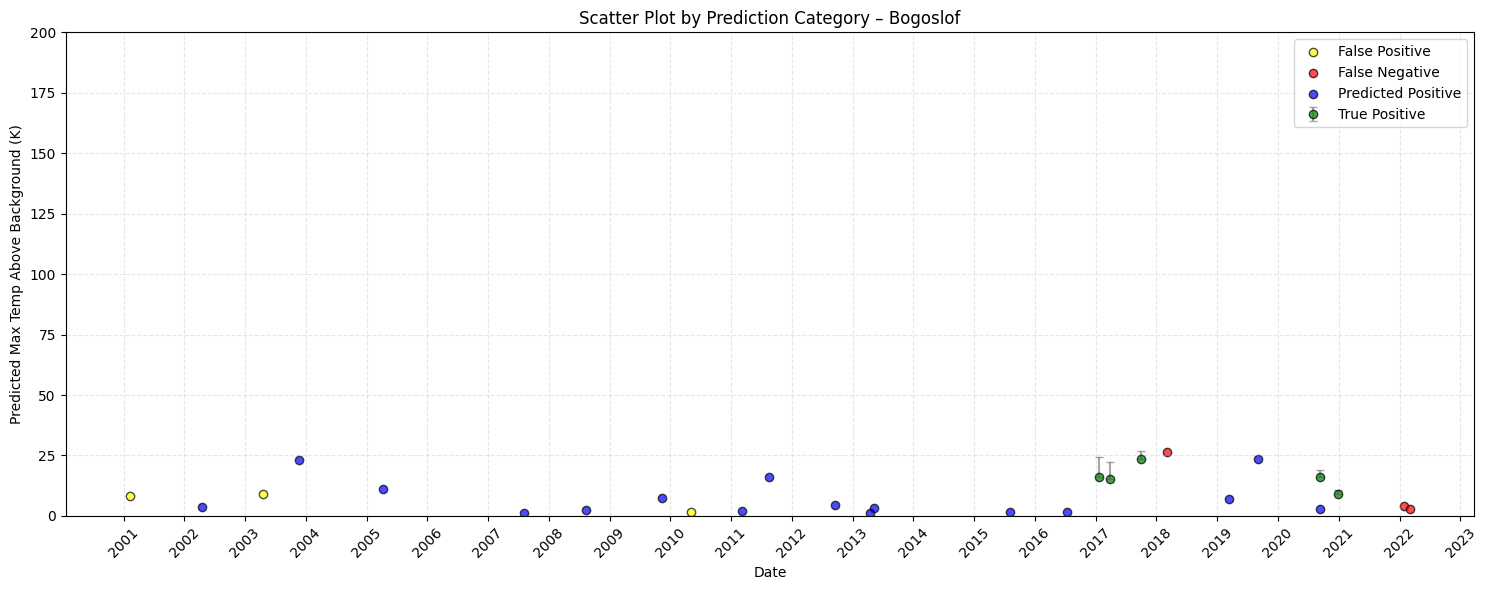

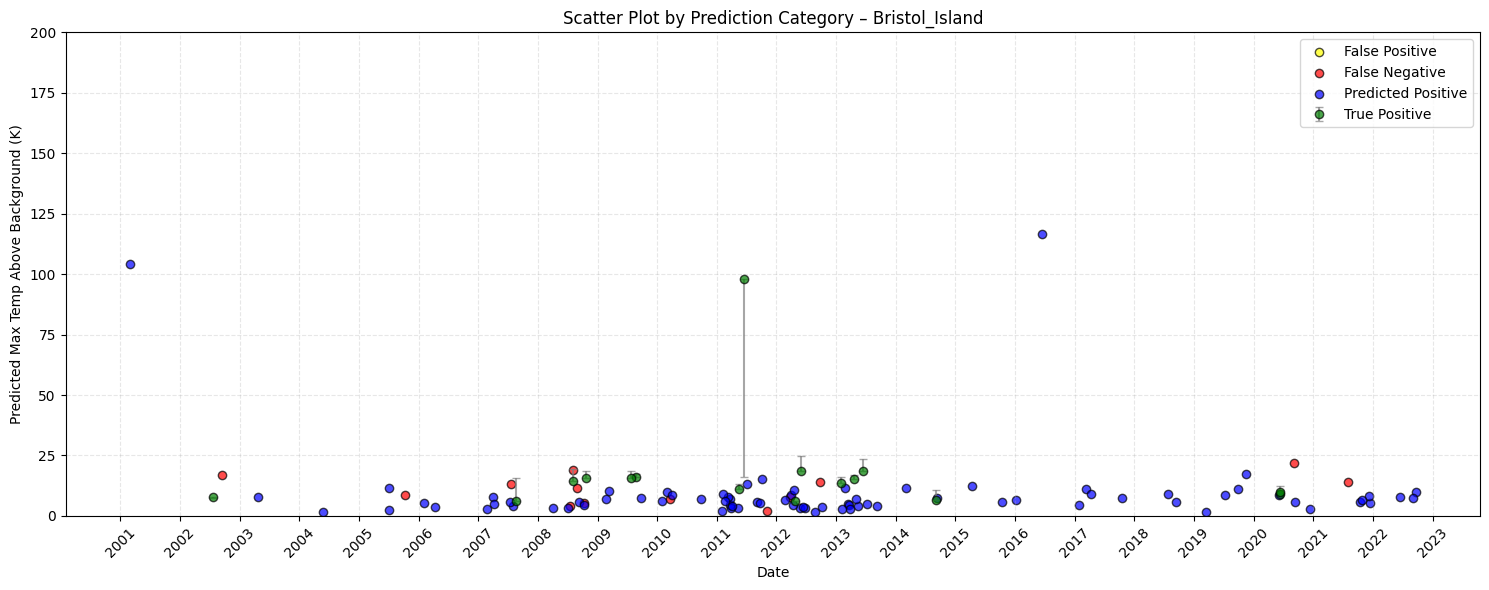

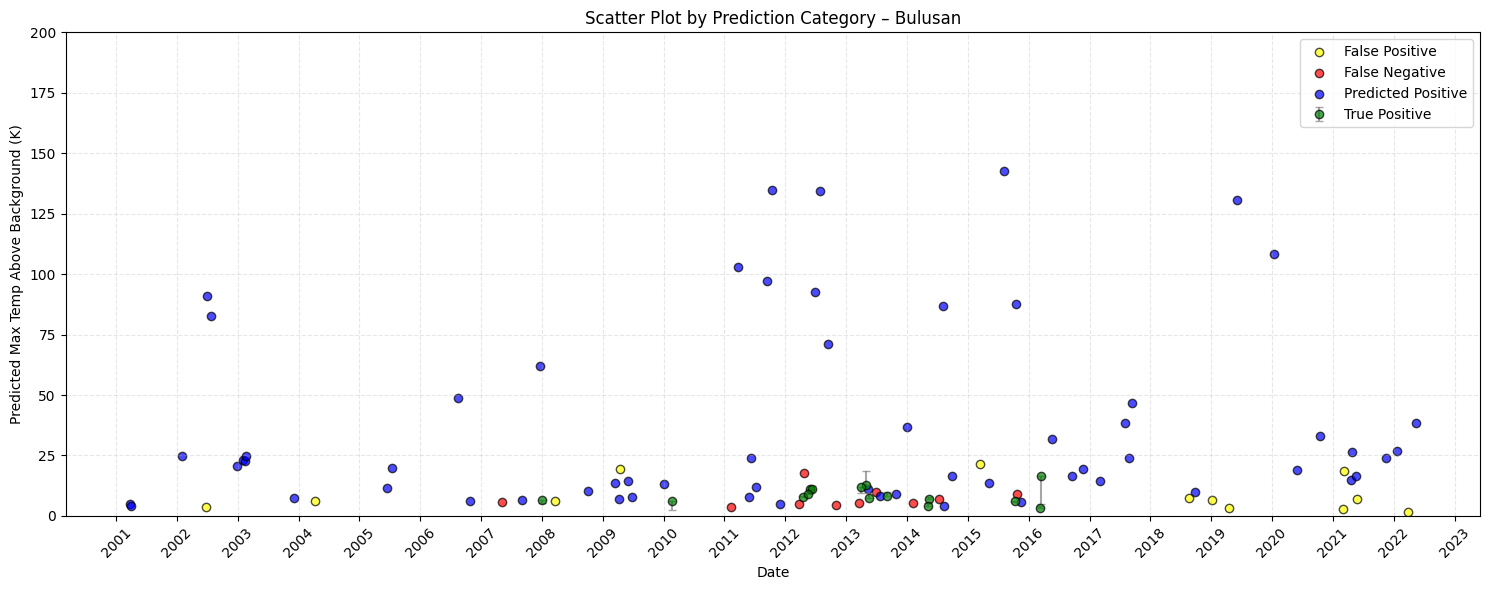

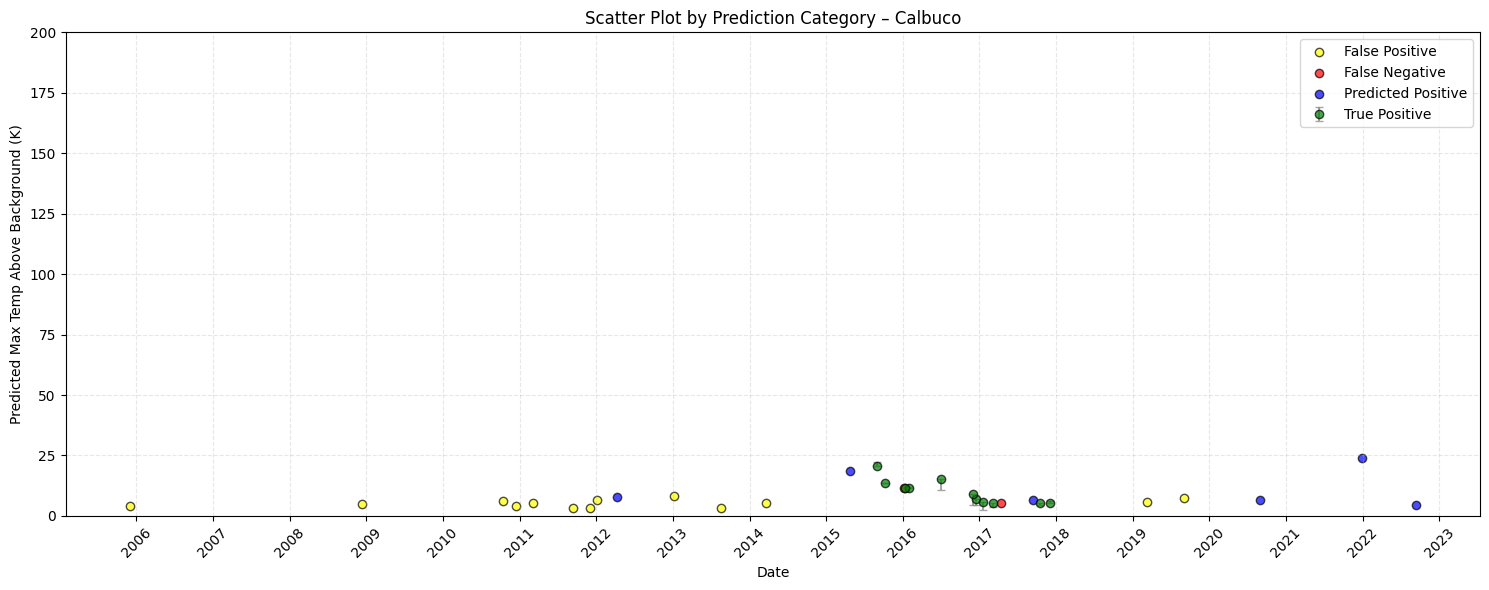

In [10]:
import matplotlib.dates as mdates
import numpy as np

df = pd.read_csv("merged_results_cleaned.csv")

# Binary encode predictions
df["y_pred"] = df["P: Volcanic Thermal Anomaly (Y/N)"].map({"Y": 1, "N": 0})
df["y_true"] = df["GT: Volcanic Thermal Anomaly (Y/N)"].map({"Y": 1, "N": 0})

# Assign categories with full GT + prediction coverage
def classify_point(gt, pred):
    if pd.isna(gt):  # ground truth is missing
        return "Predicted Positive" if pred == 1 else "Predicted Negative"
    elif pred == 1 and gt == 1:
        return "True Positive"
    elif pred == 1 and gt == 0:
        return "False Positive"
    elif pred == 0 and gt == 1:
        return "False Negative"
    else:
        return "Predicted Negative"

df["category"] = [classify_point(gt, pred) for gt, pred in zip(df["y_true"], df["y_pred"])]
df["Date"] = pd.to_datetime(df["Date"])

# Set color mapping
color_map = {
    "True Positive": "green",
    "False Positive": "yellow",
    "False Negative": "red",
    "Predicted Positive": "blue"
}

# Plot for first 20 volcanoes
for i, (volcano, group) in enumerate(df.groupby("Volcano")):
    if i >= 20:
        break

    plt.figure(figsize=(15, 6))
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    for category, color in color_map.items():
        subset = group[group["category"] == category]

        if category == "True Positive":
            y_pred = subset["P: Max Temp Above Background (K)"]
            y_gt = subset["GT: Max Temp Above Background (K)"]
            error = y_pred - y_gt
            upper = np.where(error < 0, -error, 0)  # underprediction → bar extends upward
            lower = np.where(error > 0, error, 0)   # overprediction → bar extends downward

            plt.errorbar(
                subset["Date"], y_pred,
                yerr=[lower, upper],
                fmt='o', color=color,
                label=category, alpha=0.7,
                ecolor='gray', elinewidth=1.5, capsize=3,
                markeredgecolor='black'
            )

        else:
            y_values = (
                subset["GT: Max Temp Above Background (K)"]
                if category == "False Negative"
                else subset["P: Max Temp Above Background (K)"]
            )
            plt.scatter(
                subset["Date"],
                y_values,
                c=color,
                label=category,
                alpha=0.7,
                edgecolor='black'
            )

    plt.title(f"Scatter Plot by Prediction Category – {volcano}")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.ylabel("Predicted Max Temp Above Background (K)")
    plt.ylim(0, 200)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()